In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")

import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Switches and Definitions

In [8]:
ar_of_day="AR_entire_1"
flight=["RF06"]
sector_to_plot="warm"
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
print(plot_path)
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/


In [9]:
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#        
"""
###############################################################################
    Main Script for running interpolation of griddata on flight path
###############################################################################
"""    
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
flight=cmpgn_cls.flight

In [10]:
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)
sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
#[*Dropsondes.keys()]

In [11]:
import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
        #IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds        

In [12]:
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30 ","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20 ","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
                    
new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}
from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])
print(AR_inflow["AR_inflow"].keys())
relevant_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
else:
    if flight[0]=="RF05":
        relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
        relevant_cold_sector_sondes=[4,5,6,13,14,15]
        relevant_sondes_dict["warm_sector"]        = {}
        relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
        relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3::]]
        relevant_sondes_dict["cold_sector"]        = {}
        relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
        relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
    elif flight[0]=="RF06":
        relevant_warm_sector_sondes=[0,1,2,8,9]
        relevant_cold_sector_sondes=[3,4,5,10,11,12]
        relevant_sondes_dict["warm_sector"]        = {}
        relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes]
        relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes]
        relevant_sondes_dict["cold_sector"]        = {}
        relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes]
        relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
    

Index(['time', 'Minutesofday', 'Halo_Lat', 'Halo_Lon', 'Closest_Era_Lat',
       'Closest_Era_Lon', 'Interp_IWV', 'Interp_E', 'Interp_Precip',
       'Interp_LWP', 'Interp_IWP', 'Interp_IVT', 'IVT_max_distance'],
      dtype='object')


IVT conv. mapped
Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_1_ERA5_IVTdiv.png


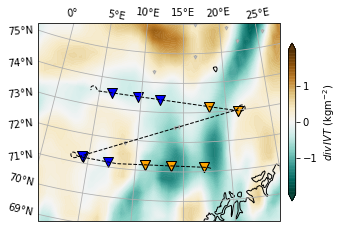

In [13]:
# Predefinitions
# Define the plot specifications for the given variables
met_var_dict={}
met_var_dict["ERA_name"]    = {"EV":"e","TP":"tp",
                                       "IWV":"tcwv","IVT":"IVT",
                                       "IVT_conv":"IVT_conv"}
met_var_dict["colormap"]    = {"EV":"Blues","IVT_conv":"BrBG_r",
                                       "TP":"Blues","IVT":"speed"}
met_var_dict["levels"]      = {"IWV":np.linspace(10,50,51),
                                       "EV":np.linspace(0,1.5,51),
                                       "TP":np.linspace(0,1.5,51),
                                       "IVT_conv":np.linspace(-2,2,101),
                                       "IVT":np.linspace(50,600,61)}
met_var_dict["units"]       = {"EV":"(kg$\mathrm{m}^{-2}$)",
                                       "TP":"(kg$\mathrm{m}^{-2}$)",
                                       "IVT_conv":"(kg$\mathrm{m}^{-2}$)",
                                       "IWV":"(kg$\mathrm{m}^{-2}\mathrm{h}^{-1}$)",
                                       "IVT":"(kg$\mathrm{m}^{-1}\mathrm{s}^{-1}$)"}
        
#############################
import matplotlib.pyplot as plt
import seaborn as sns
# Overview map
import cartopy
import matplotlib
import cartopy.crs as ccrs
        
import atmospheric_rivers as AR
import reanalysis as Reanalysis

fig_name=flight[0]+"_"+ar_of_day+"_ERA5_IVTdiv.png"
if do_plotting:
    if flight[0]=="RF05":
        central_lat=70
        central_lon=-10
    elif flight[0]=="RF06":
        central_lat=74
        central_lon=15
    last_hour=12
    #ERA5_on_HALO=era_on_halo_cls
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        
    map_fig=plt.figure(figsize=(12,8))
    ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(
                                central_longitude=central_lon,
                                central_latitude=central_lat))
    # IVT convergence as background based on ERA5
    C1=ax1.contourf(ds["longitude"],ds["latitude"],
                            ds[met_var_dict["ERA_name"]["IVT_conv"]][last_hour,:,:],
                            levels=met_var_dict["levels"]["IVT_conv"],
                            extend="both",transform=ccrs.PlateCarree(),
                            cmap=met_var_dict["colormap"]["IVT_conv"],alpha=0.95)
    print("IVT conv. mapped")

    ax1.coastlines(resolution="50m")
    gl1=ax1.gridlines(draw_labels=True,dms=True,
                          x_inline=False,y_inline=False)
    
    ax1.plot(halo_df["longitude"],halo_df["latitude"],color="k",ls="--",lw=1,transform=ccrs.PlateCarree())
    ax1.set_extent([halo_df["longitude"].min()-2,halo_df["longitude"].max()+2,
                halo_df["latitude"].min()-2,halo_df["latitude"].max()+2])
    ax1.scatter(Dropsondes["Lon"].values,Dropsondes["Lat"].values,marker="v",s=8,color="lightgrey",edgecolor="darkgrey",
            transform=ccrs.PlateCarree())
    ax1.scatter(Dropsondes["Lon"].iloc[relevant_sondes_dict["warm_sector"]["in"]],
            Dropsondes["Lat"].iloc[relevant_sondes_dict["warm_sector"]["in"]],
           marker="v",s=100,color="orange",edgecolor="k",transform=ccrs.PlateCarree())

    ax1.scatter(Dropsondes["Lon"].iloc[relevant_sondes_dict["warm_sector"]["out"]],
            Dropsondes["Lat"].iloc[relevant_sondes_dict["warm_sector"]["out"]],
           marker="v",s=100,color="orange",edgecolor="k",transform=ccrs.PlateCarree())

    ax1.scatter(Dropsondes["Lon"].iloc[relevant_sondes_dict["cold_sector"]["in"]],
            Dropsondes["Lat"].iloc[relevant_sondes_dict["cold_sector"]["in"]],
           marker="v",s=100,color="blue",edgecolor="k",transform=ccrs.PlateCarree())

    gl1.top_labels=True
    gl1.bottom_labels=False
    gl1.left_labels=True
    gl1.right_labels=False
    axins1=inset_axes(ax1,width="3%",
                              height="80%",
                              loc="center",
                              bbox_to_anchor=(0.55,0,1,1),
                              bbox_transform=ax1.transAxes,
                              borderpad=0)       
    cb=map_fig.colorbar(C1,cax=axins1)
    cb.set_label("$ div\,IVT$"+" "+met_var_dict["units"]["IVT_conv"])
    cb.set_ticks([-1.0,0,1.0])
    fig_plot_path=plot_path+fig_name
    map_fig.savefig(fig_plot_path,dpi=300,bbox_inches="tight")
    print("Figure saved as:",fig_plot_path)

In [14]:
relevant_sector_sondes={}
relevant_sector_sondes["warm"]=relevant_warm_sector_sondes
relevant_sector_sondes["cold"]=relevant_cold_sector_sondes
## --> add relevant sondes with "cold" and "warm" key.    
inflow=False
# Load config file
config_file=data_config.load_config_file(os.getcwd(),"data_config_file")
cmpgn_cls=flightcampaign.HALO_AC3(is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=flight,instruments=["radar","radiometer","sonde"])               
Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,
                 grid_name="Real_Sondes",sector_types=[sector_to_plot],do_instantan=False)

C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/data_config_file.ini
Config-file C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks//HALO_AC3


In [15]:
Moisture_CONV.perform_entire_sonde_ac3_divergence_calcs(Dropsondes,relevant_sector_sondes)
Moisture_CONV.vertically_integrated_divergence()
#Moisture_CONV.integrated_divergence

domain ready for regression
0.0        101033.710938
10.0       100912.390625
20.0       100776.093750
30.0       100649.429688
40.0       100524.109375
               ...      
11990.0     18526.529297
12000.0     18495.335938
12010.0     18464.843750
12020.0     18441.689453
12030.0     18413.652344
Length: 1204, dtype: float32


In [16]:
subgridded_q=Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].iloc[::3]
subgridded_q=subgridded_q.dropna(how="any",axis=0)
subgridded_q
subgridded_wind=Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"].iloc[::3]
subgridded_wind=subgridded_wind.dropna(how="any",axis=0)
subgridded_wind

tiled_q=np.tile(np.array(subgridded_q.index),(subgridded_q.shape[1],1))
tiled_q.shape
tiled_wind=np.tile(np.array(subgridded_wind.index),(subgridded_wind.shape[1],1))
tiled_wind.shape
print(sector_to_plot.capitalize()+" Sector Preparations Done")        

Warm Sector Preparations Done


Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_1_warm_Sondes.png


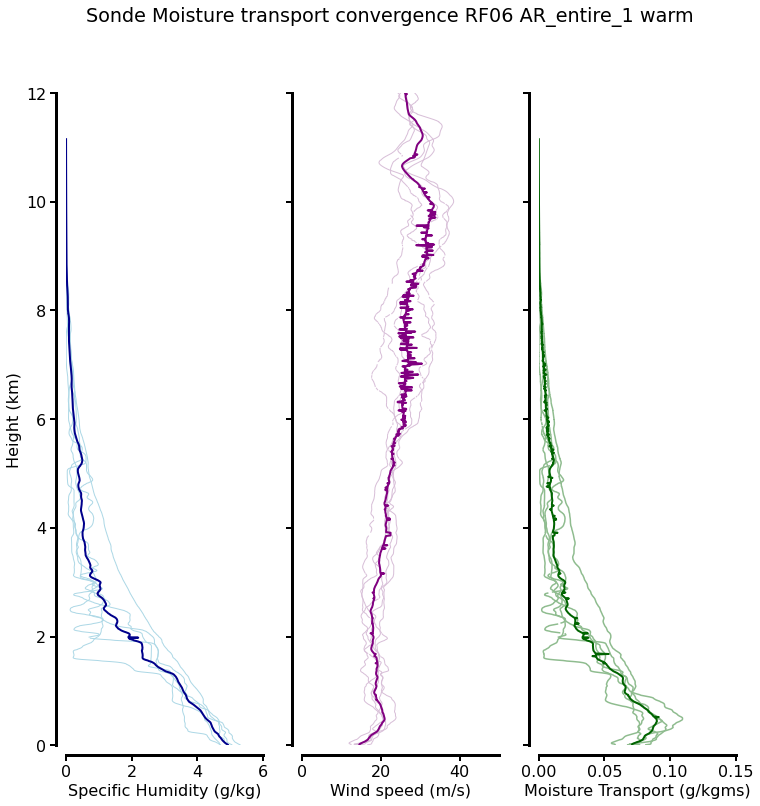

In [11]:
Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"]=\
    np.sqrt(Moisture_CONV.sector_sonde_values[sector_to_plot]["u"]**2+\
            Moisture_CONV.sector_sonde_values[sector_to_plot]["v"]**2)
if do_plotting:
    matplotlib.rcParams.update({"font.size":16})
    sonde_fig=plt.figure(figsize=(12,12))
    ax1=sonde_fig.add_subplot(131)
    ax2=sonde_fig.add_subplot(132)
    ax3=sonde_fig.add_subplot(133,sharey=ax2)
    ax1.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["q"]*1000,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="lightblue",lw=1)
    mean_sector_q=Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].mean(axis=1)
    ax1.plot(mean_sector_q*1000,mean_sector_q.index/1000,color="darkblue",lw=2)

    ax1.set_ylim([0,12])
    ax2.set_ylim([0,12])
    ax3.set_ylim([0,12])

    ax1.set_xlim([0,6])
    #wind speed
    ax2.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
         color="thistle",lw=1)
    mean_sector_wind=Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"].mean(axis=1)
    ax2.plot(mean_sector_wind,mean_sector_wind.index/1000,color="purple",lw=2)
    ax2.set_xlim([0,50])
    #transport
    mean_sector_transport=Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"].mean(axis=1)
    ax3.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="darkseagreen")
    ax3.plot(mean_sector_transport,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  lw=2,color="darkgreen")
    ax3.set_xlim([0,0.15])
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax1.set_xlabel("Specific Humidity (g/kg)")
    ax2.set_xlabel("Wind speed (m/s)")
    ax3.set_xlabel("Moisture Transport (g/kgms)")

    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    ax3.yaxis.set_tick_params(width=2,length=6)
    ax3.xaxis.set_tick_params(width=2,length=6)
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
        ax2.spines[axis].set_linewidth(3)
        ax3.spines[axis].set_linewidth(3)
    ax1.set_ylabel("Height (km)")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    plt.suptitle("Sonde Moisture transport convergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    
    sns.despine(offset=10,ax=ax1)
    sns.despine(offset=10,ax=ax2)
    sns.despine(offset=10,ax=ax3)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Sondes.png"
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

## Sonde Divergence Calculations

Figure saved as: C:\Users\u300737\Desktop\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF06_AR_entire_1_warm_sonde_moist_transp_divergence.png


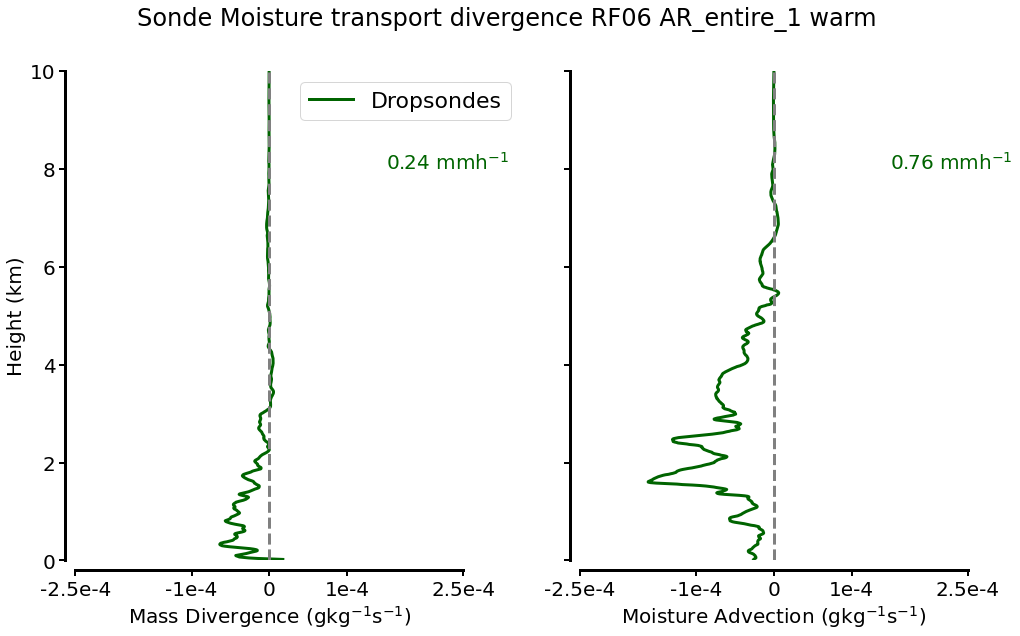

In [12]:
#%% Plotting
import seaborn as sns
matplotlib.rcParams.update({"font.size":20})
divergence_plot=plt.figure(figsize=(16,9))
ax1=divergence_plot.add_subplot(121)
ax2=divergence_plot.add_subplot(122)
# Mass divergence
ax1.plot(Moisture_CONV.div_scalar_mass[sector_to_plot].values,
         Moisture_CONV.div_scalar_mass[sector_to_plot].index.values/1000,
         color="darkgreen",lw=3,label="Dropsondes")
ax1.set_xlim([-2.5e-4,2.5e-4])
ax1.set_xticks([-2.5e-4,-1e-4,0,1e-4,2.5e-4])
ax1.set_xticklabels(["-2.5e-4","-1e-4","0","1e-4","2.5e-4"])
ax1.text(x=0.8,y=0.8,s=str(np.round(-1*Moisture_CONV.integrated_divergence[sector_to_plot]["mass_div"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax1.transAxes,color="darkgreen")
ax1.set_xlabel("Mass Divergence ($\mathrm{gkg}^{-1}\mathrm{s}^{-1}$)")
ax1.set_ylabel("Height (km)")
ax1.axvline(x=0,ls="--",lw=3,color="grey")
ax1.set_ylim([0,10])
for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(3)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_tick_params(width=2,length=6)
ax1.xaxis.set_tick_params(width=2,length=6)
ax1.legend(loc="upper right",fontsize=22,bbox_to_anchor=[1.15,1.0])
# moisture advection
ax2.plot(Moisture_CONV.adv_q_calc[sector_to_plot].values,
         Moisture_CONV.adv_q_calc[sector_to_plot].index.values/1000,
         color="darkgreen",lw=3)
ax2.set_ylim([0,10])
ax2.set_xlim([-2.5e-4,2.5e-4])
ax2.set_xticks([-2.5e-4,-1e-4,0,1e-4,2.5e-4])
ax2.set_xticklabels(["-2.5e-4","-1e-4","0","1e-4","2.5e-4"])
ax2.axvline(x=0,ls="--",lw=3,color="grey")
ax2.set_xlabel("Moisture Advection ($\mathrm{gkg}^{-1}\mathrm{s}^{-1}$)")
for axis in ['bottom','left']:
    ax2.spines[axis].set_linewidth(3)
ax2.set_yticklabels("")
ax2.text(x=0.8,y=0.8,s=str(np.round(-1*Moisture_CONV.integrated_divergence[sector_to_plot]["q_ADV"],2))+\
         " $\mathrm{mmh}^{-1}$",transform=ax2.transAxes,color="darkgreen")

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_tick_params(width=2,length=6)
ax2.xaxis.set_tick_params(width=2,length=6)
plt.suptitle("Sonde Moisture transport divergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
sns.despine(offset=10)
plt.subplots_adjust(wspace=0.3)
fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_sonde_moist_transp_divergence.png"
divergence_plot.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as:",plot_path+fig_name)

In [ ]:
"""
    sondes_selection["ind_inflow_"+sector]=np.linspace(0,
                                    AR_inflow["AR_inflow_"+sector].shape[0]-1,
                                    num=number_of_sondes+add_sonde).astype(int)
                sondes_selection["ind_outflow_"+sector]=np.linspace(0,
                                    AR_outflow["AR_outflow_"+sector].shape[0]-1,
                                    num=number_of_sondes+add_sonde).astype(int)
                sondes_selection["time_inflow_"+sector]=\
                    AR_inflow["AR_inflow_"+sector].index[\
                                    sondes_selection["ind_inflow_"+sector]]
                sondes_selection["time_outflow_"+sector]=\
                    AR_outflow["AR_outflow_"+sector].index[\
                                    sondes_selection["ind_outflow_"+sector]]
                sondes_selection["pos_inflow_"+sector]=\
                    AR_inflow["AR_inflow_"+sector][\
                            ["Halo_Lat","Halo_Lon"]].loc[\
                                    sondes_selection["time_inflow_"+sector]]
                


sys.exit()
#get relevant sondes
#warm_inflow_sondes_no=sonde_times_series.loc[inflow]      

if flight[0]=="RF06":
    if self.ar_of_day=="AR_entire_1":
        relevant_warm_sector_sondes=[0,1,8,9]
        relevant_cold_sector_sondes=[3,5,11,12] # -----> to be filled
        relevant_times=[*sonde_data["reference_time"].keys()]

sys.exit()
# cold internal leg:
#cold_start=pd.Timestamp(relevant_times[3])
#cold_end=pd.Timestamp(relevant_times[6])

# warm internal legs:
slight_time_shift=pd.Timedelta(9.5,"min")
warm_start=pd.Timestamp(relevant_times[7])+slight_time_shift
warm_end=pd.Timestamp(relevant_times[9])+slight_time_shift
radar_dbz=pd.DataFrame(data=np.array(Radar_cls.attcorr_radar_ds["dBZg"][:]).T,
                       index=pd.DatetimeIndex(np.array(Radar_cls.attcorr_radar_ds.time[:])),
                       columns=np.array(Radar_cls.attcorr_radar_ds.height[:]))

# Cold radar region
cold_radar=radar_dbz.loc[cold_start:cold_end,:]
cold_aircraft_df=aircraft_df.loc[cold_start:cold_end]
cold_radar=cold_radar[abs(cold_aircraft_df["roll"])<5]
# Warm radar region
warm_radar=radar_dbz.loc[warm_start:warm_end,:]
warm_aircraft_df=aircraft_df.loc[warm_start:warm_end]
warm_aircraft_df=warm_aircraft_df.loc[warm_radar.index]
warm_radar=warm_radar[abs(warm_aircraft_df["roll"])<5]

#BAHAMAS.bahamas_ds
    
# Quicklook Plotter
Plotter=Data_Plotter.Quicklook_Plotter(cfg_dict)
Radar_Plotter=Data_Plotter.Radar_Quicklook(cfg_dict) 
#Radar_Plotter.plot_single_radar_cfad(cold_radar,
#                                     raw_measurements=False,
#                                     is_calibrated=False)   
Radar_Plotter.plot_single_radar_cfad(warm_radar,
                                     raw_measurements=False,
                                     is_calibrated=False)   


sys.exit()
###############################################################################
relevant_sectors={}
relevant_sectors["cold"]=relevant_cold_sector_sondes
relevant_sectors["warm"]=relevant_warm_sector_sondes

## --> add relevant sondes with "cold" and "warm" key.
    
#bahamas_dict[flight]=Bahamas_cls.bahamas_ds
#radar_dict[flight]=Radar_cls.attcorr_radar_ds
inflow=False

# Load config file
config_file=data_config.load_config_file(os.getcwd(),"data_config_file")

#%% Rain 
#%% Divergence domain    
### Prepare the pattern for regression method
cmpgn_cls=Flight_Campaign.HALO_AC3(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               
cmpgn_cls.plot_path=plot_path
Moisture_CONV=Budgets.Moisture_Convergence(cmpgn_cls,flight,config_file,
                 grid_name="Real_Sondes",do_instantan=False)
Budget_plots=Budgets.Moisture_Budget_Plots(cmpgn_cls,flight,config_file,
                 grid_name="Real_Sondes",do_instantan=False)
 
relevant_times=[*sonde_data["reference_time"].keys()]

#%% cold sector
cold_relevant_times=[relevant_times[cold_time] \
                     for cold_time in relevant_cold_sector_sondes]
cold_sondes_lat=[sonde_data["reference_lat"][time].data[0] \
                 for time in cold_relevant_times]
cold_sondes_lon=[sonde_data["reference_lon"][time].data[0] \
                 for time in cold_relevant_times]


sondes_pos_all=pd.DataFrame(data=np.nan,columns=["Halo_Lat","Halo_Lon"],
                            index=pd.DatetimeIndex(cold_relevant_times))
sondes_pos_all["Halo_Lat"][:]=cold_sondes_lat
sondes_pos_all["Halo_Lon"][:]=cold_sondes_lon


# get real sondes of cross-sections:
#warm_sondes_inflow=
# Two sondes per sector
number_of_sondes=2
sondes_selection={}
for sector in ["warm_sector","core","cold_sector"]:
                add_sonde=1
                #if sector=="core":
                #    add_sonde=1
                sondes_selection["ind_inflow_"+sector]=np.linspace(0,
                                    AR_inflow["AR_inflow_"+sector].shape[0]-1,
                                    num=number_of_sondes+add_sonde).astype(int)
                sondes_selection["ind_outflow_"+sector]=np.linspace(0,
                                    AR_outflow["AR_outflow_"+sector].shape[0]-1,
                                    num=number_of_sondes+add_sonde).astype(int)
                sondes_selection["time_inflow_"+sector]=\
                    AR_inflow["AR_inflow_"+sector].index[\
                                    sondes_selection["ind_inflow_"+sector]]
                sondes_selection["time_outflow_"+sector]=\
                    AR_outflow["AR_outflow_"+sector].index[\
                                    sondes_selection["ind_outflow_"+sector]]
                sondes_selection["pos_inflow_"+sector]=\
                    AR_inflow["AR_inflow_"+sector][\
                            ["Halo_Lat","Halo_Lon"]].loc[\
                                    sondes_selection["time_inflow_"+sector]]
                sondes_selection["pos_outflow_"+sector]=\
                    AR_outflow["AR_outflow_"+sector][\
                                ["Halo_Lat","Halo_Lon"]].loc[\
                                    sondes_selection["time_outflow_"+sector]]

                sondes_selection["pos_all_"+sector]=pd.concat(\
                                    [sondes_selection["pos_inflow_"+sector],
                                     sondes_selection["pos_outflow_"+sector]])

"""